# Stereoisomer testing on ChiENN - skelettisomere

## Importing section

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys

sys.path.append("../../../../")

from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.transform import edge_graph_transform, vertex_graph_transform

## Define SMILES strings

In [2]:
smiles_list = [
    "CCCCCC",
    "CCCC(C)C",
    "CCC(C)CC",
    "CC(C)C(C)C",
    "CCC(C)(C)C",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

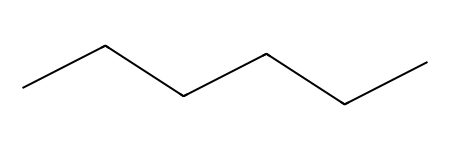

[]


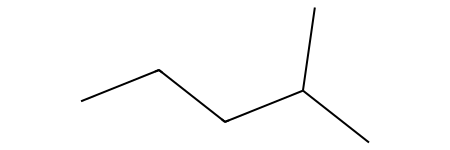

[]


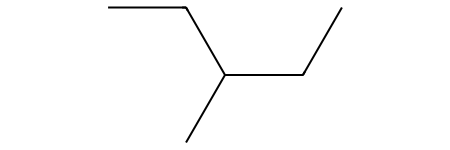

[]


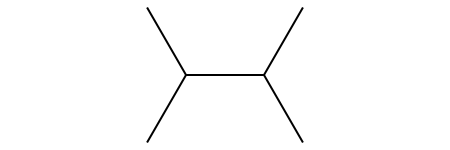

[]


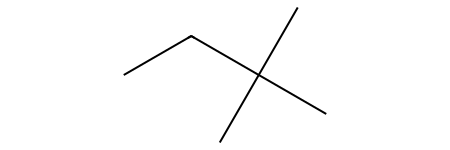

[]


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [5]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [6]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [7]:
data_list = [
    vertex_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'chiral_center_selective': True,
            'chiral_center_select_potential': False,
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [8]:
for data in data_list:
    print(data)
    print(data.ptree)

Data(x=[20, 43], edge_index=[2, 38], edge_attr=[38, 7], pos=[20, 3], ptree=[20], initial_map=[58], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])
['{"S": [0, {"P": [1, 6, 7, 8]}]}', '{"S": [1, {"P": [0, 2, 9, 10]}]}', '{"S": [2, {"P": [1, 3, 11, 12]}]}', '{"S": [3, {"P": [2, 4, 13, 14]}]}', '{"S": [4, {"P": [3, 5, 15, 16]}]}', '{"S": [5, {"P": [4, 17, 18, 19]}]}', '{"S": [6, {"P": [0]}]}', '{"S": [7, {"P": [0]}]}', '{"S": [8, {"P": [0]}]}', '{"S": [9, {"P": [1]}]}', '{"S": [10, {"P": [1]}]}', '{"S": [11, {"P": [2]}]}', '{"S": [12, {"P": [2]}]}', '{"S": [13, {"P": [3]}]}', '{"S": [14, {"P": [3]}]}', '{"S": [15, {"P": [4]}]}', '{"S": [16, {"P": [4]}]}', '{"S": [17, {"P": [5]}]}', '{"S": [18, {"P": [5]}]}', '{"S": [19, {"P": [5]}]}']
Data(x=[20, 43], edge_index=[2, 38], edge_attr=[38, 7], pos=[20, 3], ptree=[20], initial_map=[58], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_poolin

## Create Model

In [9]:
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3

model = AdvancedPermutationTreeLayer(
    hidden_dim=43,
    k=k,
    batch_norm=False
)

## Create batches

In [10]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [11]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

## Put batches through model

In [12]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [13]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all() if out_list[i].shape==out_list[j].shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True, False, False, False, False],
       [False,  True, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

In [14]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

In [15]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[0.       , 2.658502 , 2.6585019, 5.317004 , 4.0396714],
       [2.658502 , 0.       , 5.3168697, 2.658502 , 3.9357007],
       [2.6585019, 5.3168697, 0.       , 7.9752374, 1.3811693],
       [5.317004 , 2.658502 , 7.9752374, 0.       , 6.5940685],
       [4.0396714, 3.9357007, 1.3811693, 6.5940685, 0.       ]],
      dtype=float32)

Distinguishes correctly